## 06 - Lectura del Archivo NetCDF
Obtener datos de las anomalías en la superficie de la tierra desde un registro guardado en un archivo con extensión netCDF. Además se calcula su media anual.

In [3]:
#  Librerías para obtener y tratar los datos
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import pandas as pd
from datetime import timedelta,datetime

# Librerías para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [4]:
# Leo el dataframe con la información de cada borehole
df = pd.read_csv("../boreholes/dataframe.csv",index_col="Unnamed: 0")
df.head()

,Fecha,Latitud(S),Longitud(W),Primer Dato(m),Posición del Primer Dato,Profundidad(m),Conductividad Térmica(W/m/K),Gradiente Geotérmico (K/km),Path
AU_1,1969,-20.53,139.48,53.34,126,228.60,3.7599,16.270,../boreholes/raw/huang-2013-AU-1.txt
AU_10,1972,-34.00,151.25,22.86,126,449.58,2.7215,28.159,../boreholes/raw/huang-2013-AU-10.txt
AU_11,1972,-32.55,138.48,100.06,108,376.03,5.4000,17.390,../boreholes/raw/huang2016-AU-11.txt
AU_12,1969,-20.55,139.48,53.34,108,297.18,3.8300,19.090,../boreholes/raw/huang2016-AU-12.txt
AU_13,1971,-31.45,145.48,103.63,108,297.49,4.4400,23.520,../boreholes/raw/huang2016-AU-13.txt


In [5]:
# Me quedo con los datos que me interesan del dataframe
lat_borehole = list(df["Latitud(S)"])
lon_borehole = list(df["Longitud(W)"])
names = df.index

In [6]:
# Leo el archivo netCDF y me quedo con las latitudes y longitudes
data = NetCDFFile ("../../chile/datos_aire/gistemp250_GHCNv4.nc","r")

lat = data.variables["lat"][:]
lon = data.variables["lon"][:]


In [7]:
# Extraigo las anomalías del archivo netCDF 

df_sat = pd.DataFrame()
for i in range(len(lat_borehole)):
    sq_diff_lat = (lat - lat_borehole[i])**2
    sq_diff_lon = (lon - lon_borehole[i])**2
    
    # Obtengo el índice de la latitud y longitud en el netCDF
    min_index_lat = sq_diff_lat.argmin()
    min_index_lon = sq_diff_lon.argmin()
    
    temp = data.variables["tempanomaly"]
    temp_borehole =  temp [:,min_index_lat,min_index_lon]
    
    #Store time data a mi manera
    time_units = data.variables["time"].units
    starting_date = data.variables["time"].units[11:21]
    #print(starting_date) #just to know the number i have to add

    dates = []
    for data_indays in data.variables["time"]:
        specific_data = datetime(1800,1,1)
        new_date = str(specific_data + timedelta(int(data_indays)))
        new_date = new_date[0:9]
        dates.append(new_date)

    # Guardo los datos de las anomalías de los diferentes boreholes   
    df_sat[f"{names[i]}"] = temp_borehole
    
df_sat["Dates"] = dates

In [8]:
# Time format de las fechs
df_sat["Dates"] = pd.to_datetime(df_sat.Dates,format = "%Y/")
df_sat = df_sat.set_index("Dates")

In [9]:
# Media anual de las anomalías
df_sat = df_sat.resample("Y").mean()
df_sat.loc["1963-12-31"].mean()

# Media de las columnas
media_australia = df_sat.mean(axis = "columns")

Text(0, 0.5, 'Anomalías de Temperatura Registradas en el Aire')

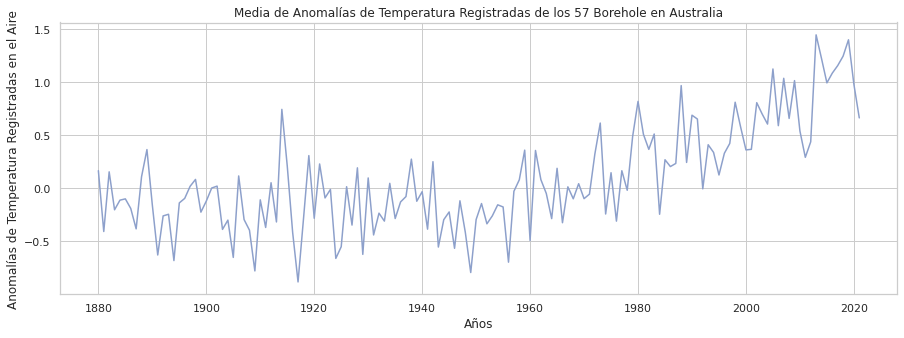

In [10]:
# Plot de las anomalías obtenidas del netCDF
urteak = list(range(1880,2022))

plt.figure(figsize=(15,5))
plt.plot(urteak,media_australia,color=sns.color_palette('Set2')[2])
plt.title("Media de Anomalías de Temperatura Registradas de los 57 Borehole en Australia")
plt.xlabel("Años")
plt.ylabel("Anomalías de Temperatura Registradas en el Aire")

In [11]:
# "Normalización" de las anomalias
erref = media_australia[urteak.index(1972):urteak.index(1990)]
To = (sum(erref)/len(erref))

anom_airean = []
for k in media_australia:
    anom_airean.append(k - To)

Text(0.5, 1.0, 'Corrección de Anomalías de Temperatura Registradas en Australia')

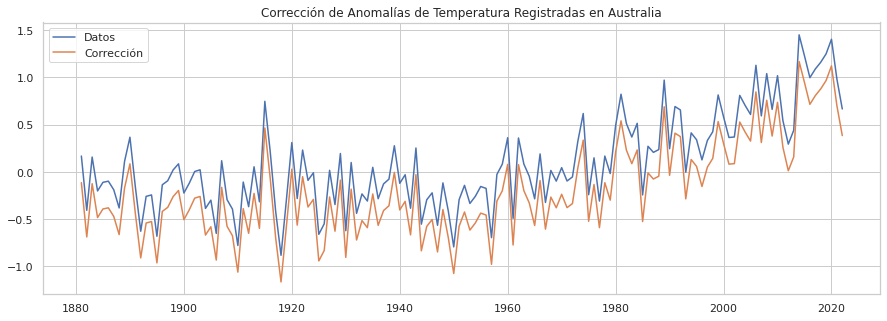

In [12]:
# Plot de las anomalías normalizas y de las anomalías obtenidas directamente del netCDF
plt.figure(figsize=(15,5))
plt.plot(df_sat.index,media_australia,label="Datos")
plt.plot(df_sat.index,anom_airean,label="Corrección")
plt.legend()
plt.title(f"Corrección de Anomalías de Temperatura Registradas en Australia")

In [13]:
 # Guardo el vector con las anomalías "normalizadas"
 np.savetxt(f"../resultados/datos/anomalias_aire.csv",anom_airean,delimiter=",")
